# Grad CAM

[Grad-CAM](https://github.com/nejlag/Grad-CAM)

In [1]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
import os
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "7"


def build_model(hp):
    output_dim = 3

    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))

    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 3, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=14, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice(
            "activation_" + str(i), values=["relu", "elu", "tanh"]
        )
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)

        # create layer
        model.add(
            keras.layers.Conv2D(
                hp_units,
                hp_kernel,
                strides=(hp_strides_0, hp_strides_1),
                padding="same",
            )
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(output_dim, activation="linear"))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanAbsoluteError(),
        # loss=keras.losses.MeanSquaredError(),
        metrics=["accuracy"],
    )
    print(model.summary())

    return model


tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    directory="mapper_tuning_v5",
    project_name="mapper_tuning_20db",
)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)

2025-04-28 08:33:41.430450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 08:33:42.066939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-04-28 08:33:43.594498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Reloading Tuner from mapper_tuning_v5/mapper_tuning_20db/tuner0.json
{'num_layers': 4, 'units_1': 10, 'kernel_1': 2, 'units_0_1': 2, 'units_1_1': 2, 'activation_1': 'relu', 'dropout_1': 0.2, 'units_2': 10, 'kernel_2': 12, 'units_0_2': 3, 'units_1_2': 2, 'activation_2': 'relu', 'dropout_2': 0.1, 'learning_rate': 0.01, 'units_3': 10, 'kernel_3': 14, 'units_0_3': 4, 'units_1_3': 4, 'activation_3': 'tanh', 'dropout_3': 0.2, 'units_4': 6, 'kernel_4': 2, 'units_0_4': 3, 'units_1_4': 4, 'activation_4': 'elu', 'dropout_4': 0.1, 'units_5': 14, 'kernel_5': 10, 'units_0_5': 4, 'units_1_5': 2, 'activation_5': 'elu', 'dropout_5': 0.30000000000000004, 'units_6': 14, 'kernel_6': 2, 'units_0_6': 3, 'units_1_6': 3, 'activation_6': 'tanh', 'dropout_6': 0.8, 'tuner/epochs': 50, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 512, 10)    │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 512, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 256, 10)    │        14,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 256, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 64, 10)      │        19,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 64, 10)      │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 64, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 64, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         5,763 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,953 (156.07 KB)

 Trainable params: 39,893 (155.83 KB)

 Non-trainable params: 60 (240.00 B)

None


In [2]:
model.load_weights("src/weights_v5/mapper_model_20.weights.h5")

/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
for layer in model.layers:
    if isinstance(layer, keras.layers.Conv2D):
        print(f"Layer: {layer.name}")
        print(f"  Kernel Size: {layer.kernel_size}")
        print(f"  Stride: {layer.strides}")
        print(f"  Padding: {layer.padding}")
        print(f"  Filters: {layer.filters}")
        # print(f"  Input Channels: {layer.input_shape[-1]}")
        print(f"  Weights Shape: {layer.get_weights()[0].shape}")
        print()

Layer: conv2d
  Kernel Size: (2, 2)
  Stride: (2, 2)
  Padding: same
  Filters: 10
  Weights Shape: (2, 2, 1, 10)

Layer: conv2d_1
  Kernel Size: (12, 12)
  Stride: (3, 2)
  Padding: same
  Filters: 10
  Weights Shape: (12, 12, 10, 10)

Layer: conv2d_2
  Kernel Size: (14, 14)
  Stride: (4, 4)
  Padding: same
  Filters: 10
  Weights Shape: (14, 14, 10, 10)



Filter shape: (2, 2, 1, 10)


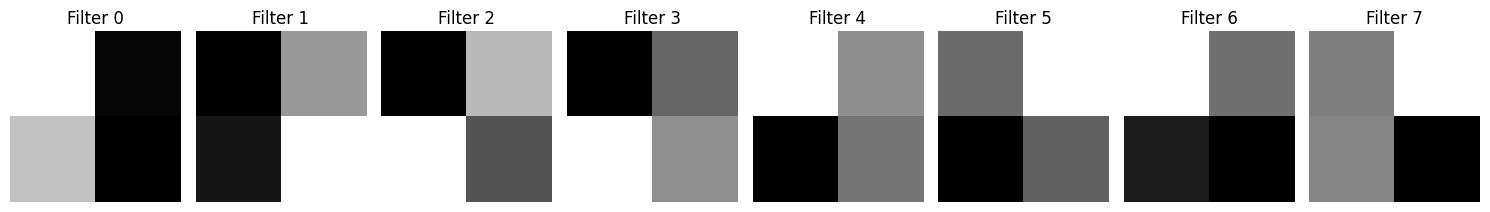

In [4]:
import matplotlib.pyplot as plt
import numpy as np

conv_layer = next(
    layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)
)

filters, biases = conv_layer.get_weights()
print("Filter shape:", filters.shape)  # (kernel_h, kernel_w, in_channels, out_channels)

num_filters = min(filters.shape[3], 8)

fig, axs = plt.subplots(1, num_filters, figsize=(15, 3))
for i in range(num_filters):
    f = filters[:, :, 0, i]
    axs[i].imshow(f, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Filter {i}")
plt.tight_layout()
plt.show()

In [5]:
activations = []

for layer in model.layers:
    if hasattr(layer, "activation"):
        activations.append(
            {
                "Layer Name": layer.name,
                "Layer Type": type(layer).__name__,
                "Activation": layer.activation.__name__,
            }
        )

df_activations = pd.DataFrame(activations)
print(df_activations)

     Layer Name  Layer Type Activation
0        conv2d      Conv2D     linear
1    activation  Activation       relu
2      conv2d_1      Conv2D     linear
3  activation_1  Activation       relu
4      conv2d_2      Conv2D     linear
5  activation_2  Activation       tanh
6         dense       Dense     linear


In [6]:
for layer in model.layers:
    if isinstance(layer, keras.layers.Dropout):
        print(f"Layer: {layer.name}, Dropout-Rate: {layer.rate}")

Layer: dropout, Dropout-Rate: 0.2
Layer: dropout_1, Dropout-Rate: 0.1
Layer: dropout_2, Dropout-Rate: 0.2


In [7]:
from src.data_util import load_augmented_example

In [8]:
load_path = "/data/PulHypStudie_Check_npz_v5_SNR20/"
pig_test_s_dict = {
    "P_01_PulHyp": 10338,
    "P_02_PulHyp": 12859,
    "P_03_PulHyp": 8124,
    "P_04_PulHyp": 8914,
    "P_05_PulHyp": 10063,
    "P_06_PulHyp": 6934,
    "P_07_PulHyp": 5692,
    "P_08_PulHyp": 7189,
    "P_09_PulHyp": 8228,
    "P_10_PulHyp": 6552,
}

# load pig 10 as the test pig
pigs_test = ["P_10_PulHyp"]
sample_skip = pig_test_s_dict[pigs_test[0]]
print(f"{sample_skip=}")

X_10, y_10, clrs_pig_10 = load_augmented_example(
    load_path,
    pigs_test,
    sample_skip=sample_skip,
    load_samples="downwards",
    shuffle=False,
)

sample_skip=6552
Selected 6552 from /data/PulHypStudie_Check_npz_v5_SNR20/P_10_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v5_SNR20/P_10_PulHyp/sample_006551.npz from pig P_10_PulHyp.


In [9]:
X_10.shape, y_10.shape

((6552, 64, 1024, 1), (6552, 3))

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

for layer in model.layers[:]:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print("Last Conv-layer:", layer.name)

Last Conv-layer: conv2d
Last Conv-layer: conv2d_1
Last Conv-layer: conv2d_2


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 512, 10)    │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 512, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 512, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 256, 10)    │        14,410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 256, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 64, 10)      │        19,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 64, 10)      │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 64, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 64, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         5,763 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,953 (156.07 KB)

 Trainable params: 39,893 (155.83 KB)

 Non-trainable params: 60 (240.00 B)

In [14]:
dummy_input = X_10[:20, ...]
dummy_label = y_10[:20, ...]

In [37]:
import pickle
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom


def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2d_1"):
    grad_model = keras.models.Model(
        [model.get_layer("conv2d").input],
        [model.get_layer(last_conv_layer_name).output, model.get_layer("dense").output],
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
    return conv_outputs[:, ...]  # np.mean(conv_outputs,axis=(0,1))


def plot_layer_output(output, layer):
    print("filterdims", output.shape)

    filtr = 0
    original_image = output[0, :, :, filtr]
    target_shape = (256, 256)
    zoom_factors = (
        target_shape[0] / original_image.shape[0],
        target_shape[1] / original_image.shape[1],
    )

    resized_image = zoom(original_image, zoom_factors)
    resized_image = (resized_image - np.min(resized_image)) / (
        np.max(resized_image) - np.min(resized_image)
    )

    plt.imshow(resized_image, aspect="auto", extent=[0, 10, 512, 0])
    plt.xlabel(f"Time dimension (1 - {int(original_image.shape[0])})")
    plt.ylabel(f"EIT dimension (1 - {int(original_image.shape[1])})")
    plt.title(f"{layer}. Conv2d")
    plt.colorbar(label="Impact")
    plt.show()

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom


def plot_layer_output(output, layer):
    print("filterdims", output.shape)
    num_filters = output.shape[-1]
    target_shape = (256, 256)

    fig, axes = plt.subplots(1, num_filters, figsize=(20, 2), sharey=True)
    axes = axes.flatten()

    for filtr in range(num_filters):
        original_image = output[0, :, :, filtr]
        zoom_factors = (
            target_shape[0] / original_image.shape[0],
            target_shape[1] / original_image.shape[1],
        )
        resized_image = zoom(original_image, zoom_factors)
        resized_image = (resized_image - np.min(resized_image)) / (
            np.max(resized_image) - np.min(resized_image)
        )
        ax = axes[filtr]
        im = ax.imshow(
            resized_image,
            aspect="auto",
            extent=[0, original_image.shape[1], original_image.shape[0], 0],
        )
        ax.set_title(f"Layer{layer} - Filter {filtr+1}")
        # ax.set_xlabel('Time dimension')
        # if filtr == 0:
        #    ax.set_ylabel('EIT dimension')
        # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

filterdims (1, 32, 512, 10)


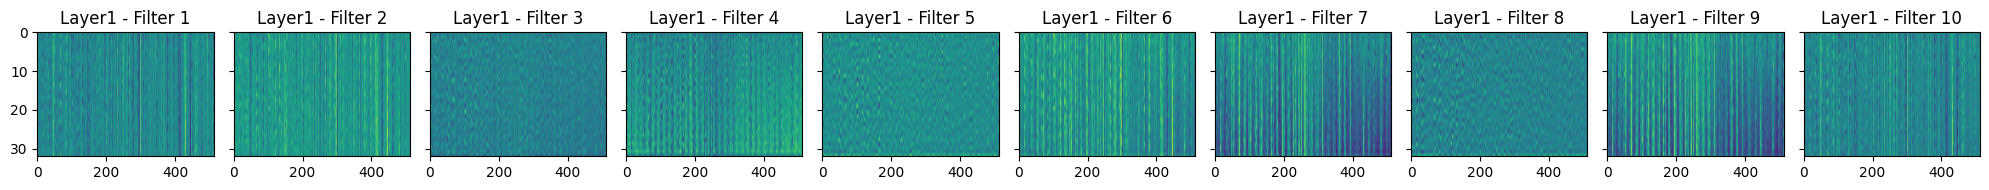

filterdims (1, 11, 256, 10)


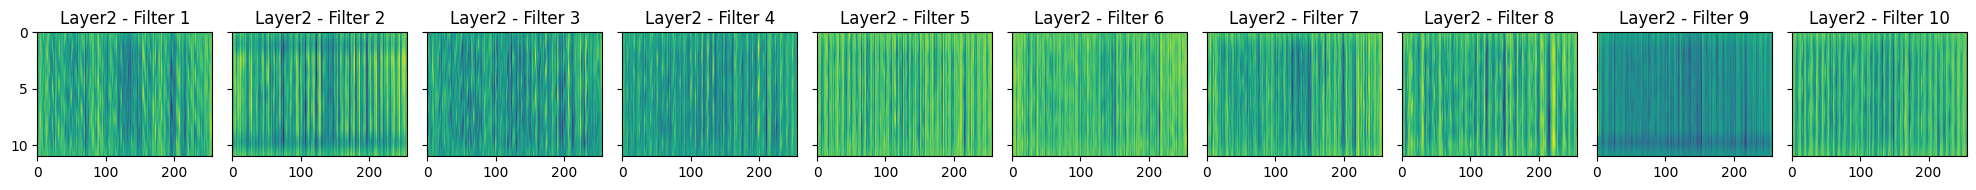

filterdims (1, 3, 64, 10)


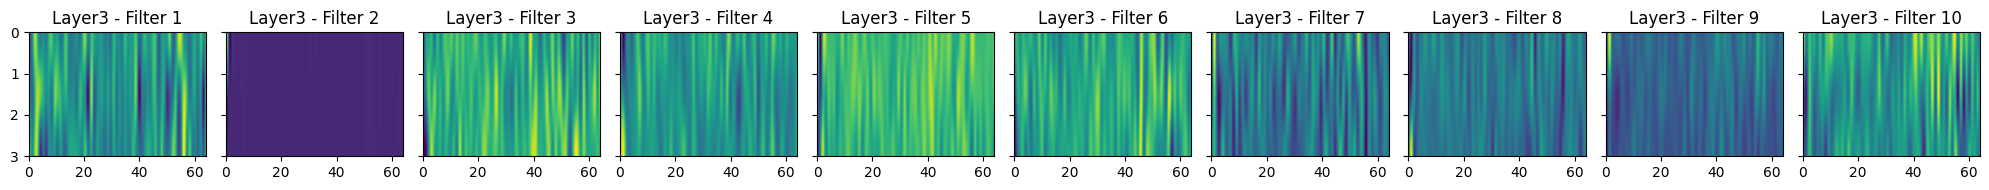

In [101]:
last_conv_layer_name = "conv2d"
layer_num = 1

i = 2

output = make_gradcam_heatmap(X_10[i : i + 1], model, last_conv_layer_name)
plot_layer_output(output, layer_num)

last_conv_layer_name = "conv2d_1"
layer_num = 2
output = make_gradcam_heatmap(X_10[i : i + 1], model, last_conv_layer_name)
plot_layer_output(output, layer_num)

last_conv_layer_name = "conv2d_2"
layer_num = 3
output = make_gradcam_heatmap(X_10[i : i + 1], model, last_conv_layer_name)
plot_layer_output(output, layer_num)

## Visualization of CNN input samples

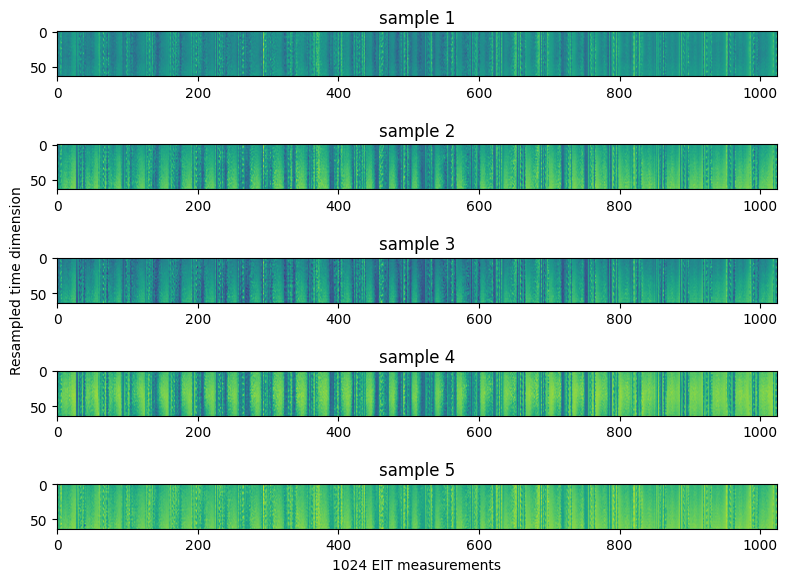

In [19]:
import matplotlib.pyplot as plt

num_images = 5
fig, axes = plt.subplots(num_images, 1, figsize=(8, 6))
for i in range(num_images):
    ax = axes[i]
    ax.imshow(X_10[i, :, :, 0], cmap="viridis")
    ax.set_title(f"sample {i+1}")
axes[2].set_ylabel("Resampled time dimension")
plt.xlabel("1024 EIT measurements")
plt.tight_layout()
# plt.savefig("1.2.B.pdf")
plt.show()